# Sales Forecasting 

---

<img src="https://assets.website-files.com/60e7f71b22c6d0b9cf329ceb/621e1a2f28ded71ee95aeede_6ProvenSalesForecastingMethodstoDriveRevenue1_a117440b5ae227c3dba5264a6521da06_2000.png" width="1000" />


## Project Structure


1. Problem Statement
2. Loading Libraries and Data
3. Data Preprocessing
4. Feature extraction and exploration
5. Training and Validation data
6. Time Series Forecasting models
7. Machine Learning models

## 1. Problem Statement

SimpleBuy is a clothing company. Be it parent, child, man, woman, they have wide range of products catering to the need to every individual. They aim to become one stop destination for all clothing desires.
 
Their idea of offline and online channels is doing quite well. Their stock now runs out even faster than they could replenish it. Customers are no longer skeptical about their quality. Their offline stores help customer to physically check clothes before buying them, especially the expensive clothes. In addition, their delivery channels are known to achieve six sigma efficiency.
 
However, SimpleBuy can only provide this experience, if they can manage the stocks well. Hence, they need to forecast the sales ahead of time. And this is where you will help them in collecting the raw material and planning the manufacturing process. SimpleBuy has provided you with their Sales data for last 2 years and they want to you predict the sales for next 6 months.

## 2. Loading Libraries and Data

In [1]:
#importing required libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from math import sqrt
from statistics import mean, stdev
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"D:\ML-Project\Sales Forecasting Time Analysis\data\Sales data.csv")

In [3]:
df.head()

,Date,Sales
0,01-Jan-07,31.762
1,02-Jan-07,285.955
2,03-Jan-07,740.781
3,04-Jan-07,508.796
4,05-Jan-07,445.951


In [4]:
df.tail()

,Date,Sales
582,20-Dec-08,10572.461
583,21-Dec-08,11507.413
584,22-Dec-08,13640.882
585,23-Dec-08,8821.786
586,24-Dec-08,192532.706


In [5]:
df.shape

(587, 2)

- We have daily sales data for two years, starting from 1-jan-07 to 24-dec-08.
- Using this historical data, we need to forecast the demand expected in the next 6 months. 

Let us do some basic exploration and find out if the given data has any trend or seasonal patterns.

## 3. Data Preprocessing

### Plotting Time Series

In [6]:
df['Date'] = pd.to_datetime(df['Date'],format = '%d-%b-%y')
df.index = df['Date']

In [7]:
df

,Date,Sales
Date,,
2007-01-01,2007-01-01,31.762
2007-01-02,2007-01-02,285.955
2007-01-03,2007-01-03,740.781
2007-01-04,2007-01-04,508.796
2007-01-05,2007-01-05,445.951
...,...,...
2008-12-20,2008-12-20,10572.461
2008-12-21,2008-12-21,11507.413
2008-12-22,2008-12-22,13640.882


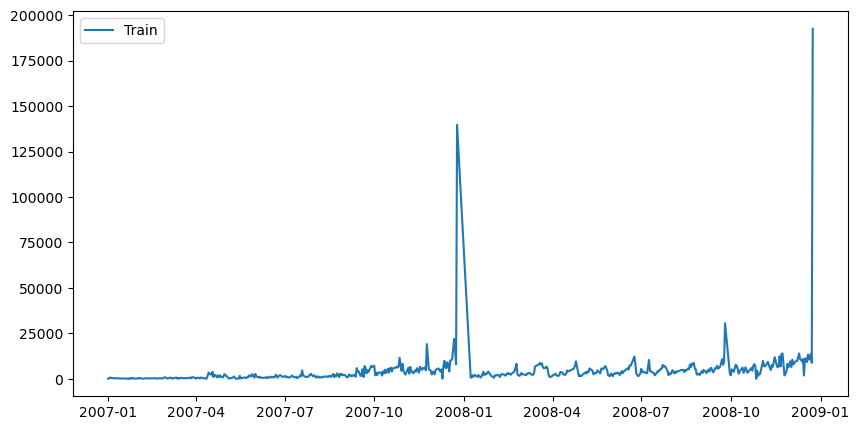

In [8]:
plt.figure(figsize = (10,5))

plt.plot(df.index, df['Sales'],label = 'Train')
plt.legend()
plt.show()


In [9]:
df['Sales'].describe()

count       587.000000
mean       4118.111549
std       10150.995301
min          31.762000
25%        1075.948500
50%        2784.444000
75%        5208.588000
max      192532.706000
Name: Sales, dtype: float64

- As we can see that there is a huge difference in 75th percentile and max values. So,let's find out 95, 97 and 99 percentile to check out outliers 

In [10]:
print('Value at 95th Percentile:',round(np.percentile(df['Sales'],95),3))
print('Value at 97th Percentile:',round(np.percentile(df['Sales'],97),3))
print('Value at 99th Percentile:',round(np.percentile(df['Sales'],99),3))

Value at 95th Percentile: 9855.528
Value at 97th Percentile: 10975.127
Value at 99th Percentile: 14225.473


<AxesSubplot:xlabel='Sales'>

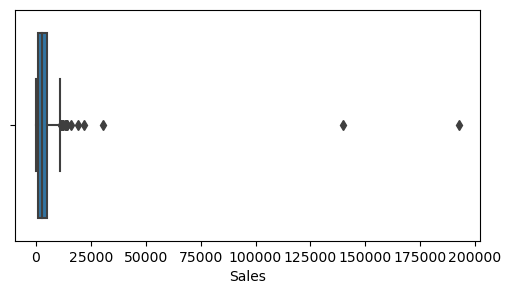

In [11]:
plt.figure(figsize = (6,3))
sns.boxplot(df['Sales'])

In [12]:
def get_whisker_boundaries(col):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    IQR = q3 - q1

    lower_limit = q1 - 1.5 * IQR
    upper_limit = q3 + 1.5 * IQR

    return lower_limit,upper_limit

In [13]:
lower_value, upper_value = get_whisker_boundaries('Sales')

print('Lower Whisker Value is:',lower_value)
print('Upper Whisker Value is:',upper_value)

df_outliers = df.loc[df['Sales']>upper_value]

print('Rows containing outliers:',df_outliers.shape)

Lower Whisker Value is: -5123.0107499999995
Upper Whisker Value is: 11407.54725
Rows containing outliers: (16, 2)


- We can use either the 95th percentile value or whisker value to select outliers
- There are 16 points greater than whisker value
- Replace the outliers with bfill or ffill

In [14]:
df_outliers.head()

,Date,Sales
Date,,
2007-10-27,2007-10-27,11572.492
2007-11-24,2007-11-24,19138.073
2007-12-22,2007-12-22,21956.074
2007-12-23,2007-12-23,15766.750
2007-12-25,2007-12-25,139629.635


In [15]:
new_df = df.copy()

#replace outliers with NaN values
new_df['Sales'] = new_df['Sales'].apply(lambda x: np.nan if x>upper_value else x)

In [16]:
#check for missing values
new_df['Sales'].isnull().sum()

16

In [17]:
#fill nan values with ffill value

new_df['Sales'] = new_df['Sales'].fillna(method='ffill')

In [18]:
#check for missing values
new_df['Sales'].isnull().sum()

0

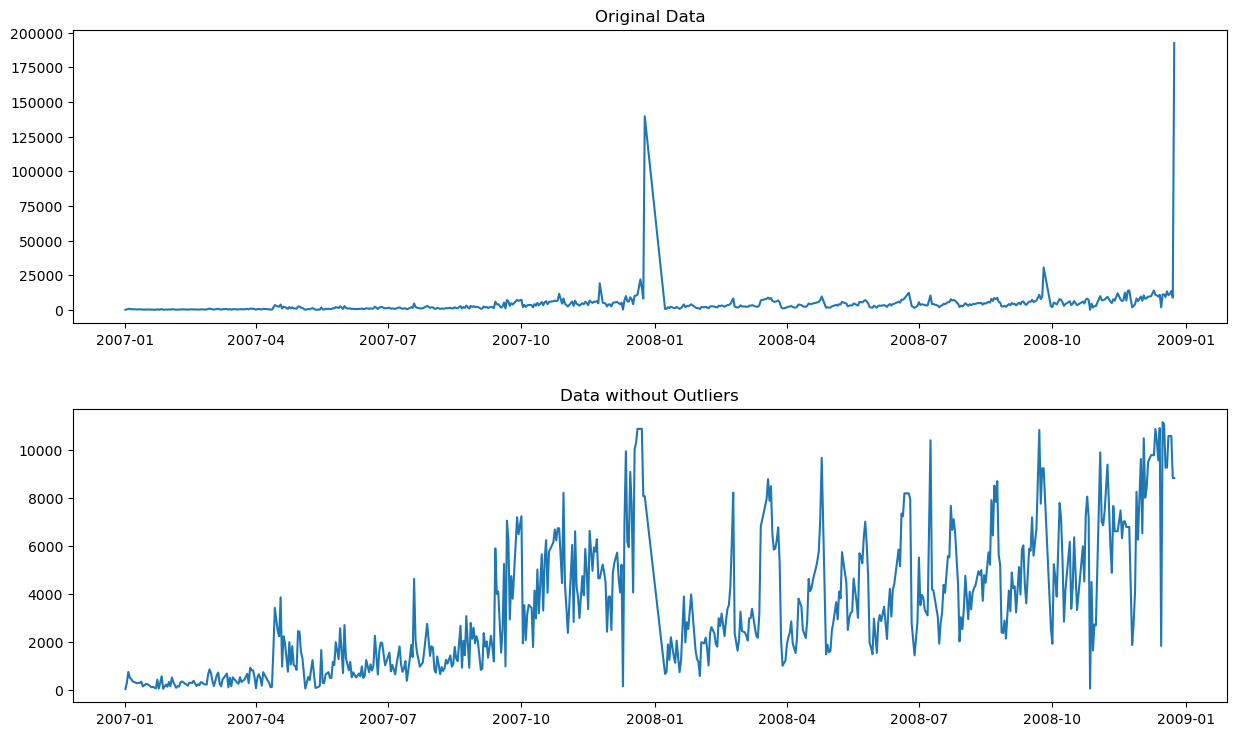

In [19]:
fig,ax = plt.subplots(2,1, figsize=(13,8))

ax[0].plot(df['Sales'])
ax[1].plot(new_df['Sales'])

ax[0].set_title("Original Data")
ax[1].set_title("Data without Outliers")

plt.tight_layout(pad=3)
plt.show()

### Missing Date Values in Data 

In [20]:
new_df['Date'].min(),new_df['Date'].max()

(Timestamp('2007-01-01 00:00:00'), Timestamp('2008-12-24 00:00:00'))

In [21]:
print('Total days between 01-jan-07 to 24-Dec-08:', (new_df['Date'].max() - new_df['Date'].min()).days)
print('Number of rows present in the data are:', new_df.shape[0])

Total days between 01-jan-07 to 24-Dec-08: 723
Number of rows present in the data are: 587


In [22]:
#missing dates in data
pd.date_range(start = '2007-01-01', end = '2008-12-24' ).difference(new_df.index)

DatetimeIndex(['2007-01-07', '2007-01-08', '2007-01-10', '2007-01-14',
               '2007-01-17', '2007-01-21', '2007-01-25', '2007-01-28',
               '2007-02-04', '2007-02-10',
               ...
               '2008-11-01', '2008-11-02', '2008-11-07', '2008-11-09',
               '2008-11-14', '2008-11-16', '2008-11-24', '2008-11-30',
               '2008-12-07', '2008-12-09'],
              dtype='datetime64[ns]', length=137, freq=None)

- There are 137 days missing over the span of two years. 
- Are these weekends? Or Holidays? 
- Are these days missing at random?

Let's find out

In [23]:
start_date = new_df['Date'].min().date()
last_date = new_df['Date'].max().date()

In [24]:
data = pd.date_range(start = start_date, end = last_date).difference(new_df.index)
missing_dates = pd.DataFrame(data = data, columns= ['Date'])

In [25]:
missing_dates['Day'] = missing_dates['Date'].dt.strftime('%A')
missing_dates['Month'] = missing_dates['Date'].dt.month_name()
missing_dates['Year'] = missing_dates['Date'].dt.year

In [26]:
missing_dates.head()

,Date,Day,Month,Year
0,2007-01-07,Sunday,January,2007
1,2007-01-08,Monday,January,2007
2,2007-01-10,Wednesday,January,2007
3,2007-01-14,Sunday,January,2007
4,2007-01-17,Wednesday,January,2007


In [27]:
missing_dates['Day'].value_counts()

Sunday       86
Saturday     14
Monday       10
Friday       10
Wednesday     6
Thursday      6
Tuesday       5
Name: Day, dtype: int64

In [28]:
missing_dates['Month'].value_counts()

January      19
June         13
July         13
September    13
March        12
November     12
May          10
October      10
December     10
February      9
April         9
August        7
Name: Month, dtype: int64

In [29]:
pd.crosstab(missing_dates['Year'],missing_dates['Day'])

Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Year,,,,,,,
2007,3,4,6,43,5,1,5
2008,7,6,8,43,1,4,1


In [30]:
pd.crosstab(missing_dates['Year'],missing_dates['Month'])

Month,April,August,December,February,January,July,June,March,May,November,October,September
Year,,,,,,,,,,,,
2007,4,3,8,6,8,7,5,6,6,4,5,5
2008,5,4,2,3,11,6,8,6,4,8,5,8


- Most of the missing days are Sundays
- Remaining 51 missing days are from Mon-Fri
- January has seen most of the missing days

Conclusions:
1. We will not make predictions for Sunday
2. We will make predictions for all weekdays
3. Discuss with stakeholders for manual adjustments on Sunday and holiday

### Dealing with Missing Values

In [31]:
#add rows for missing days
data = pd.DataFrame(new_df['Sales'])
data.index = new_df.index

In [32]:
data.shape

(587, 1)

In [33]:
#add missing dates to data
idx = pd.date_range(start_date,last_date)
data = data.reindex(idx,fill_value=np.nan)

In [34]:
data.head(10)

,Sales
2007-01-01,31.762
2007-01-02,285.955
2007-01-03,740.781
2007-01-04,508.796
2007-01-05,445.951
2007-01-06,347.351
2007-01-07,NaN
2007-01-08,NaN
2007-01-09,269.415
2007-01-10,NaN


In [35]:
data['Date'] = data.index
data['weekday'] = data['Date'].dt.strftime('%A')
data.head()

,Sales,Date,weekday
2007-01-01,31.762,2007-01-01,Monday
2007-01-02,285.955,2007-01-02,Tuesday
2007-01-03,740.781,2007-01-03,Wednesday
2007-01-04,508.796,2007-01-04,Thursday
2007-01-05,445.951,2007-01-05,Friday


In [36]:
data = data.loc[data['weekday']!='Sunday']
data.shape

(621, 3)

In [37]:
data.isnull().sum()

Sales      51
Date        0
weekday     0
dtype: int64

In [38]:
#fill nan values with ffill value
data['Sales'] = data['Sales'].fillna(method='ffill')

In [39]:
data.isnull().sum()

Sales      0
Date       0
weekday    0
dtype: int64

## 4. Feature Extraction and Exploration 

### Decompose Series

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_series = seasonal_decompose(data['Sales'],period=6)

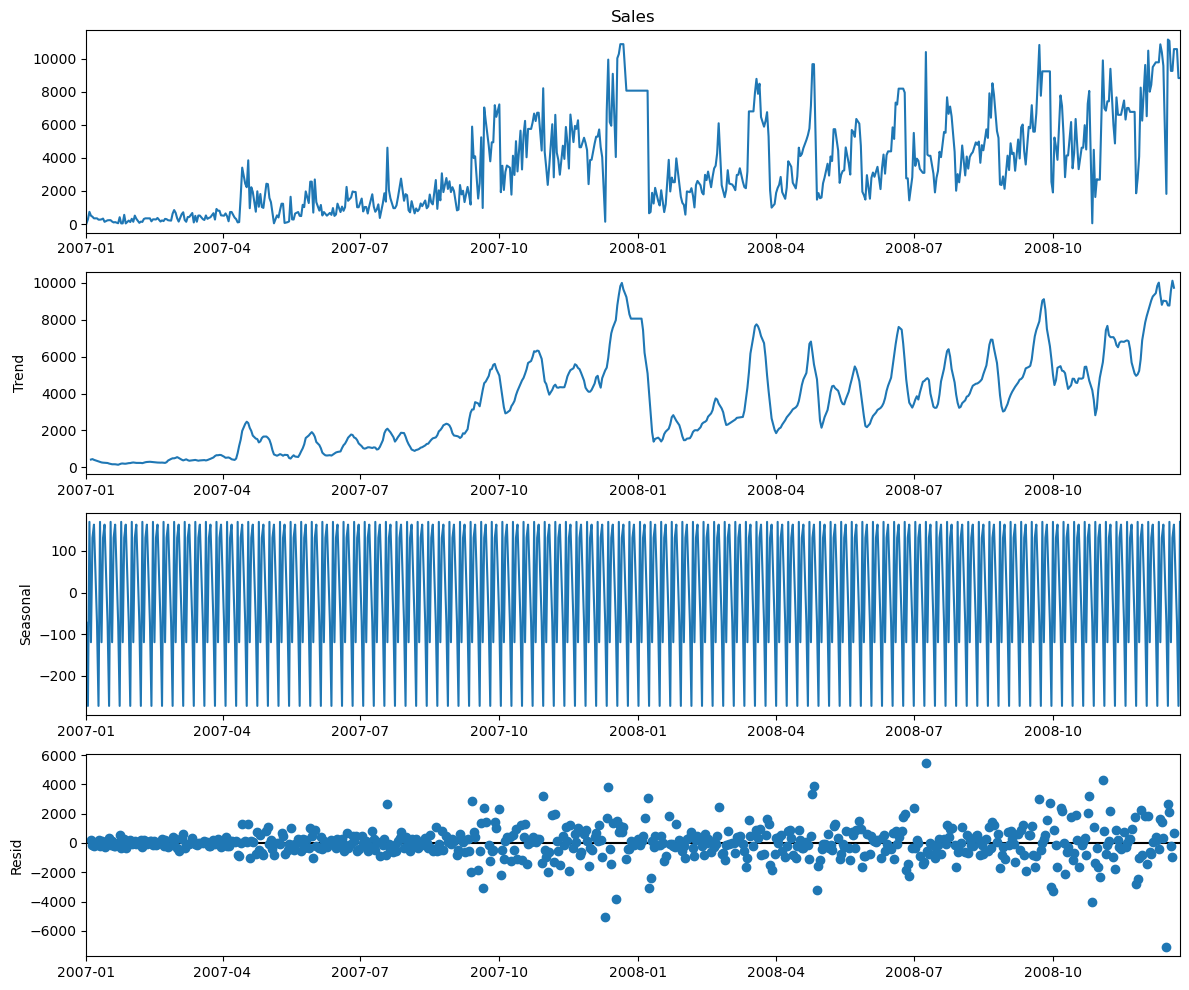

In [41]:
fig = decomposed_series.plot()
fig.set_size_inches((12,10))
fig.tight_layout()

<AxesSubplot:>

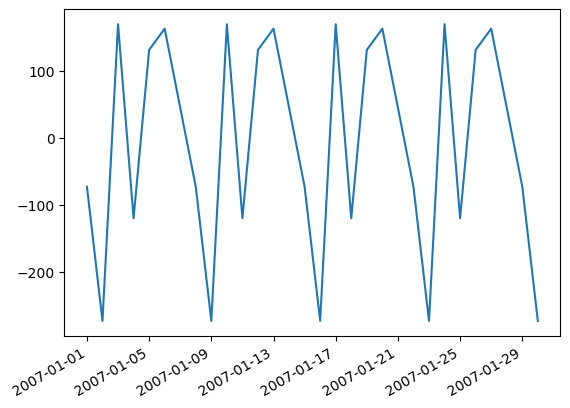

In [42]:
# considering 26 days a month 
decomposed_series.seasonal[0:26].plot()

- Pattern repeats 4 times a month
- This suggests weekly seasonality in the data

In [43]:
data_feat = pd.DataFrame({"year": data['Date'].dt.year,
                          "month": data['Date'].dt.month,
                          "dayofmonth": data['Date'].dt.day,
                          "weekday": data['Date'].dt.dayofweek,
                          "dayofyear": data['Date'].dt.dayofyear,
                          "week": data['Date'].dt.week,
                          "quarter": data['Date'].dt.quarter,
                         })

In [44]:
complete_data = pd.concat([data_feat,data['Sales']],axis =1)
complete_data.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter,Sales
2007-01-01,2007,1,1,0,1,1,1,31.762
2007-01-02,2007,1,2,1,2,1,1,285.955
2007-01-03,2007,1,3,2,3,1,1,740.781
2007-01-04,2007,1,4,3,4,1,1,508.796
2007-01-05,2007,1,5,4,5,1,1,445.951


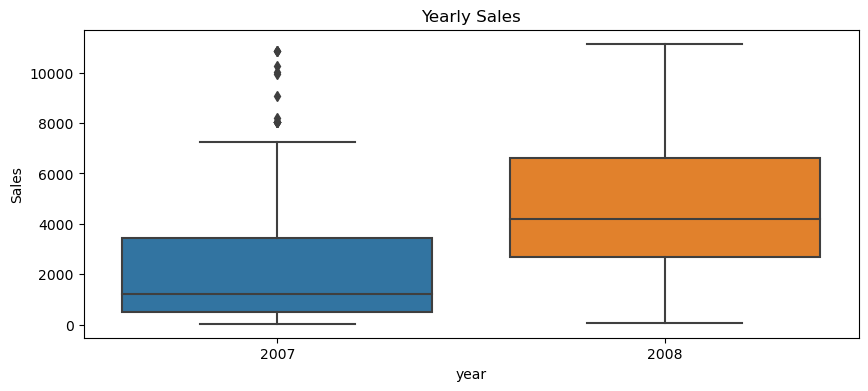

In [45]:
# boxplot for yearly sale
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['year'], y=complete_data['Sales'])
plt.title('Yearly Sales')
plt.show()

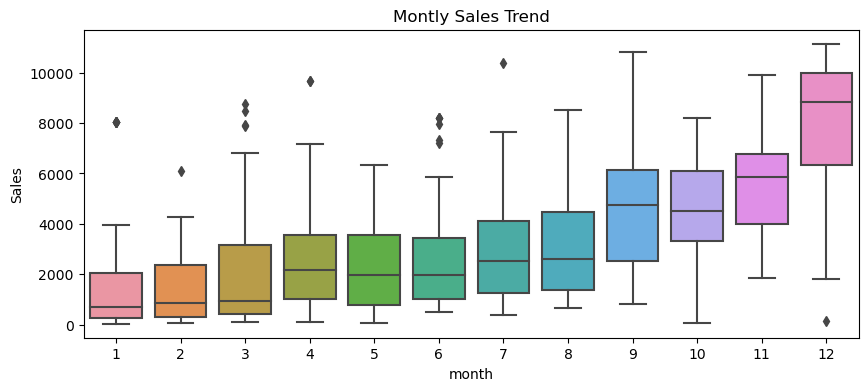

In [46]:
# boxplot for monthly sales
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['month'], y=complete_data['Sales'], )
plt.title('Montly Sales Trend')
plt.show()

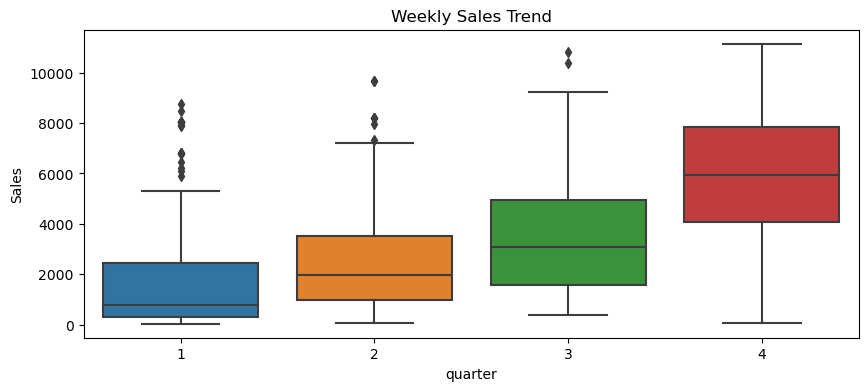

In [47]:
# boxplot for week's sales
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['quarter'], y=complete_data['Sales'], )
plt.title('Weekly Sales Trend')
plt.show()

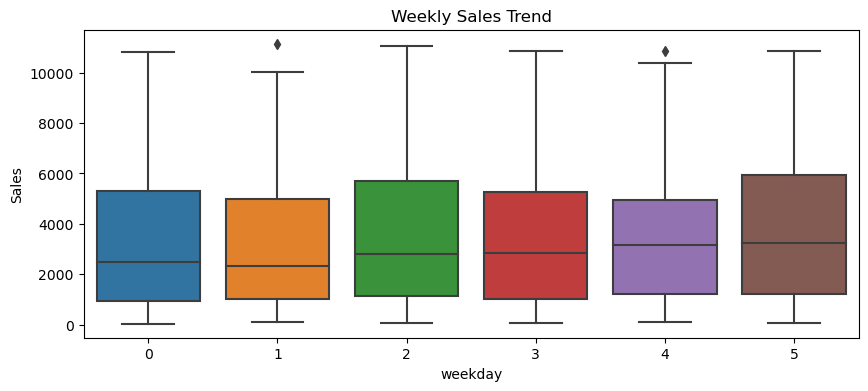

In [48]:
# boxplot for week's sales
plt.figure(figsize=(10,4))

sns.boxplot(x=complete_data['weekday'], y=complete_data['Sales'], )
plt.title('Weekly Sales Trend')
plt.show()

- Except for a few high sales in 2007, sales were comparatively higher in 2008
- All weekdays have similar trend on sales
- Average sales are higher towards the end of the year

## 5. Holdout Validation

In [49]:
model_data = pd.DataFrame(data['Sales'],index=data['Date'])

In [50]:
model_data

,Sales
Date,
2007-01-01,31.762
2007-01-02,285.955
2007-01-03,740.781
2007-01-04,508.796
2007-01-05,445.951
...,...
2008-12-19,9254.530
2008-12-20,10572.461
2008-12-22,10572.461


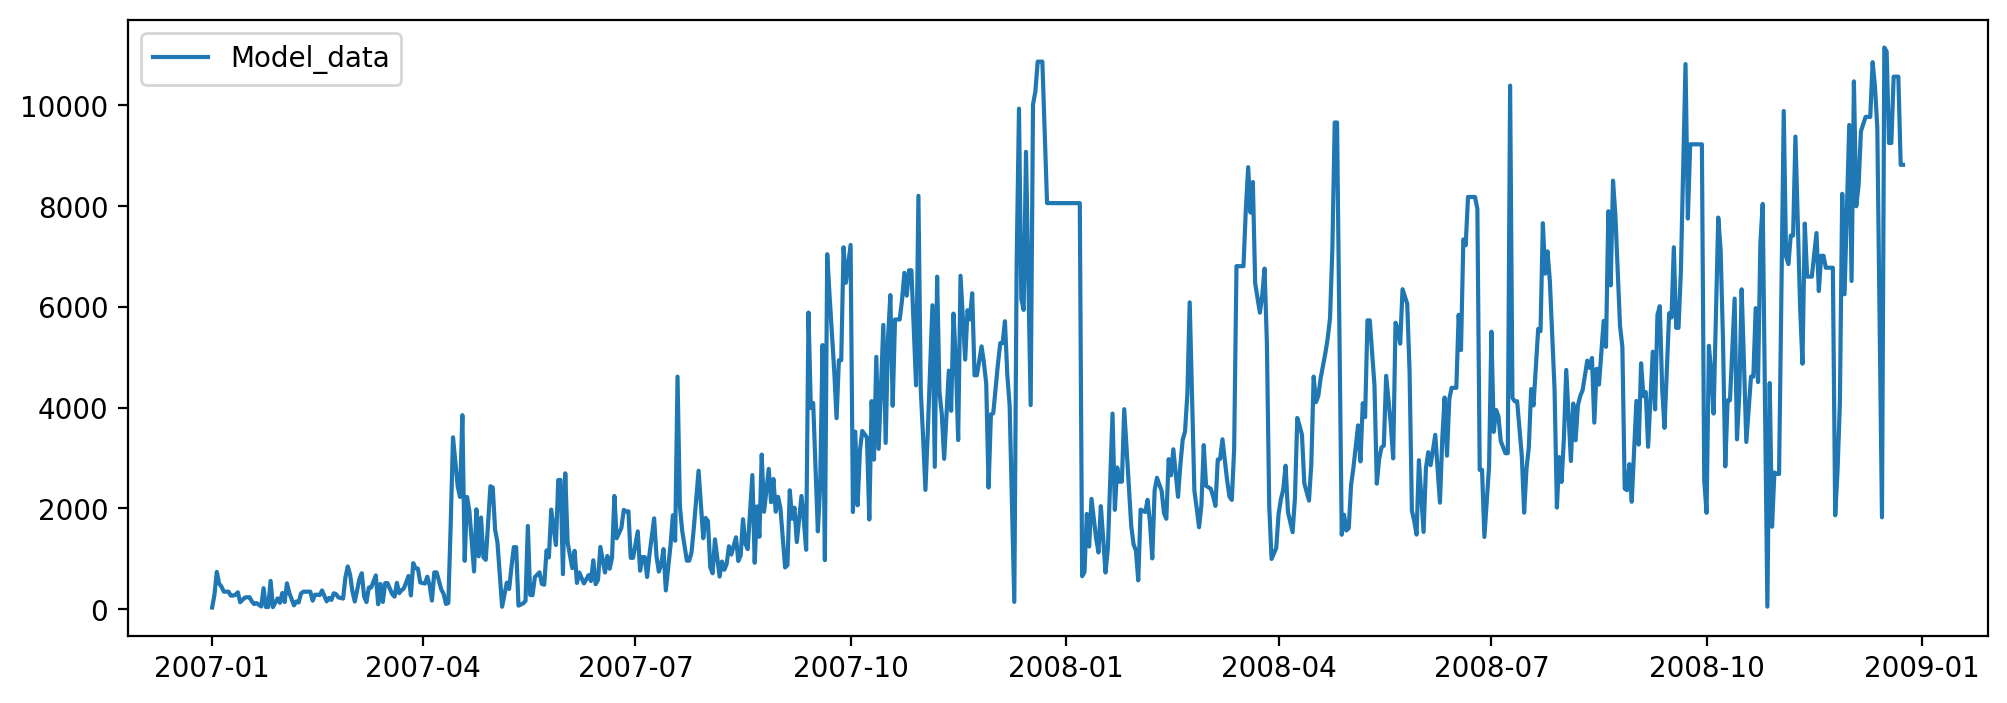

In [51]:
plt.figure(figsize = (12,4),dpi = 200)

plt.plot(model_data['Sales'],label = 'Model_data')
plt.legend()
plt.show()

In [52]:
train_data = model_data[:469]
validation_data = model_data[469:]

In [53]:
validation_data.head()

,Sales
Date,
2008-07-01,5508.723
2008-07-02,3519.382
2008-07-03,3955.195
2008-07-04,3832.665
2008-07-05,3336.381


In [54]:
validation_data.tail()

,Sales
Date,
2008-12-19,9254.530
2008-12-20,10572.461
2008-12-22,10572.461
2008-12-23,8821.786
2008-12-24,8821.786


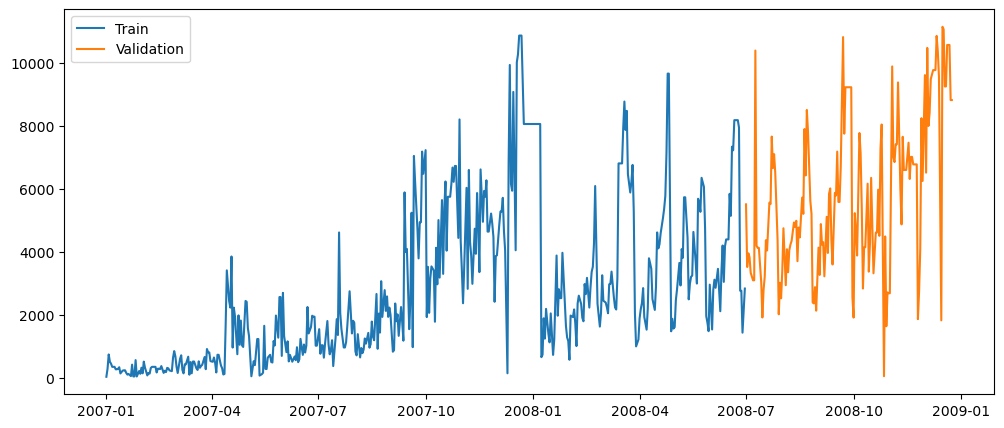

In [55]:
plt.figure(figsize=(12,5))

plt.plot(train_data['Sales'], label='Train')
plt.plot(validation_data['Sales'], label='Validation')
plt.legend(loc='best')
plt.show()

In [56]:
def rmsle(actual, preds):
    
    for i in range(0,len(preds)):
        if preds[i] < 0:
            preds[i] = 0
        else:
            pass
    
    error = (sqrt(mean_squared_log_error(actual, preds)))
    return error

## 6. Time Series Forecasting Models

### Holt's Winters (a.k.a. Triple Enponential Smoothing)

In [57]:
#import module
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#training the model
model = ExponentialSmoothing(np.asarray(train_data['Sales']),seasonal_periods=6, trend = 'add',seasonal='add')
model = model.fit(smoothing_level=0.2, smoothing_trend=0.001, smoothing_seasonal=0.2)

#prediction and evaluation
preds = model.forecast(len(validation_data))
error = rmsle(actual=validation_data['Sales'],preds=preds)

#results
print("RMSLE score for Holt's Winter is",error)

RMSLE score for Holt's Winter is 0.5894667982861534


## Grid Search

In [58]:
from itertools import product
from tqdm import tqdm_notebook

In [59]:
# setting initial values and some bounds for them
smoothing_level = [0.1, 0.3, 0.5, 0.8]
smoothing_slope = [0.0001, 0.001, 0.05] 
smoothing_seasonal = [0.2, 0.4, 0.6]

# creating list with all the possible combinations of parameters
parameters = product(smoothing_level, smoothing_slope, smoothing_seasonal)
parameters_list = list(parameters)
len(parameters_list)

36

In [60]:
def grid_search(parameters_list):
    
    results = []
    best_error_ = float("inf")

    for param in tqdm_notebook(parameters_list):
        
        #training the model
        model= ExponentialSmoothing(np.asarray(train_data['Sales']),seasonal_periods=6,trend='add',seasonal='add')
        model= model.fit(smoothing_level=param[0], smoothing_slope=param[1], smoothing_seasonal=param[2])

        # predictions and evaluation
        preds = model.forecast(len(validation_data)) 
        score = rmsle(actual=validation_data['Sales'],preds=preds)
        
        # saving best model, rmse and parameters
        if score < best_error_:
            best_model = model
            best_error_ = score
            best_param = param
        results.append([param, score])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'RMSLE']
    
    
    # sorting in ascending order, the lower rmse is - the better
    result_table = result_table.sort_values(by='RMSLE', ascending=True).reset_index(drop=True)
    
    return result_table

In [61]:
result_table = grid_search(parameters_list)

  0%|          | 0/36 [00:00<?, ?it/s]

In [62]:
result_table.parameters[0],result_table.RMSLE[0]

((0.1, 0.0001, 0.2), 0.5815996189411103)

In [63]:
#training the model
model = ExponentialSmoothing(np.asarray(train_data['Sales']), seasonal_periods=6, trend='add', seasonal='add')
model = model.fit(smoothing_level=0.1, smoothing_slope=0.0001, smoothing_seasonal=0.2)
    
# predictions and evaluation
preds = model.forecast(len(validation_data)) 
error = rmsle(validation_data['Sales'], preds)

# results
print('RMSLE for Holt Winter is:', error)

RMSLE for Holt Winter is: 0.5815996189411103


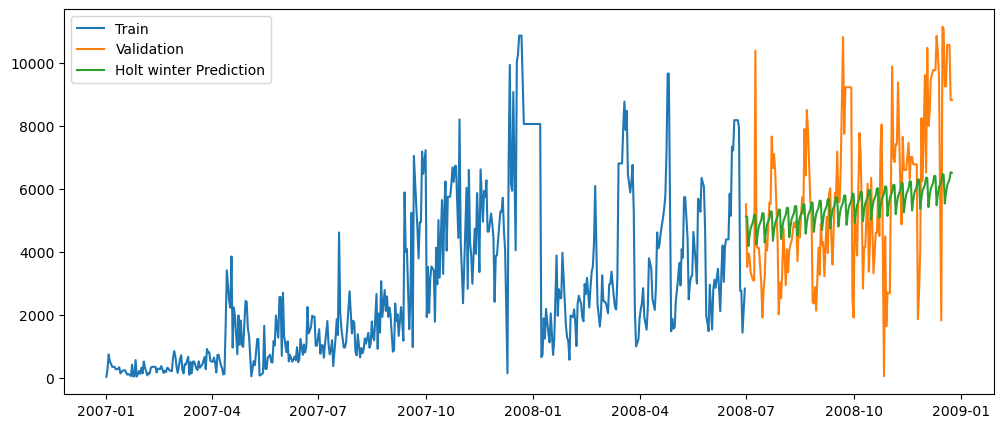

In [64]:
plt.figure(figsize=(12,5))

plt.plot(train_data.index, train_data['Sales'], label='Train')
plt.plot(validation_data.index, validation_data['Sales'], label='Validation')
plt.plot(validation_data.index, preds, label='Holt winter Prediction')
plt.legend(loc='best')
plt.show()

## ARIMA Model and SARIMA Model

## Stationarity Tests

Two statistical tests which we will be discussing are

### 1. Augmented Dickey-Fuller (ADF) Test

- ADF test is conducted with the following assumptions.
- Null Hypothesis (HO): Series is non-stationary.
- Alternate Hypothesis(HA): Series is stationary.
- If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

- Conditions to Reject Null Hypothesis(HO)

- If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series is stationary. It does not have a time-dependent structure.

### 2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

- KPSS test is conducted with the following assumptions.
- Null Hypothesis (HO): Series is trend stationary or series has no unit root.
- Alternate Hypothesis(HA): Series is non-stationary or series has a unit root.
- Note: Hypothesis is reversed in KPSS test compared to ADF Test.
- If the null hypothesis is failed to be rejected, this test may provide evidence that the series is trend stationary.

- Conditions to Fail to Reject Null Hypothesis(HO)
- If Test statistic < Critical Value and p-value < 0.05 – Fail to Reject Null Hypothesis(HO) i.e., time series is trend stationary.

In [65]:
def adf_test(timeseries):
    
    #perdform dickey fuller test
    print('Result of Augmented Dickey fuller (ADF) Test:')
    adf_test = adfuller(timeseries,autolag='AIC')
    adf_output = pd.Series(adf_test[:4],index=['Test Statistics','p-value','No. of lags used','No. of observations used'])
    
    for key, value in adf_test[4].items():
        adf_output['Critical Vlaue (%s)' %key] = value
        
    print(adf_output)        

In [66]:
adf_test(model_data['Sales'])

Result of Augmented Dickey fuller (ADF) Test:
Test Statistics              -2.384756
p-value                       0.146085
No. of lags used             13.000000
No. of observations used    607.000000
Critical Vlaue (1%)          -3.441169
Critical Vlaue (5%)          -2.866313
Critical Vlaue (10%)         -2.569312
dtype: float64


 If the p-value is less than the 0.05, we can reject the null hypothesis (aka the series is stationary). When the p-value is greater than 0.05, we fail to reject the null hypothesis (which means the series is not stationary). **Here test statistic is > than critical. Hence series is not stationary**

### Making Series Stationary

In [67]:
train_data['Sales_log'], lambda_ar = stats.boxcox(train_data['Sales'])
lambda_ar

0.27524553717944616

In [68]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [69]:
#perform differencing to make series stationary (weekly seasonality)
train_data['Sales_log_diff']=train_data['Sales_log']-train_data['Sales_log'].shift(6) 

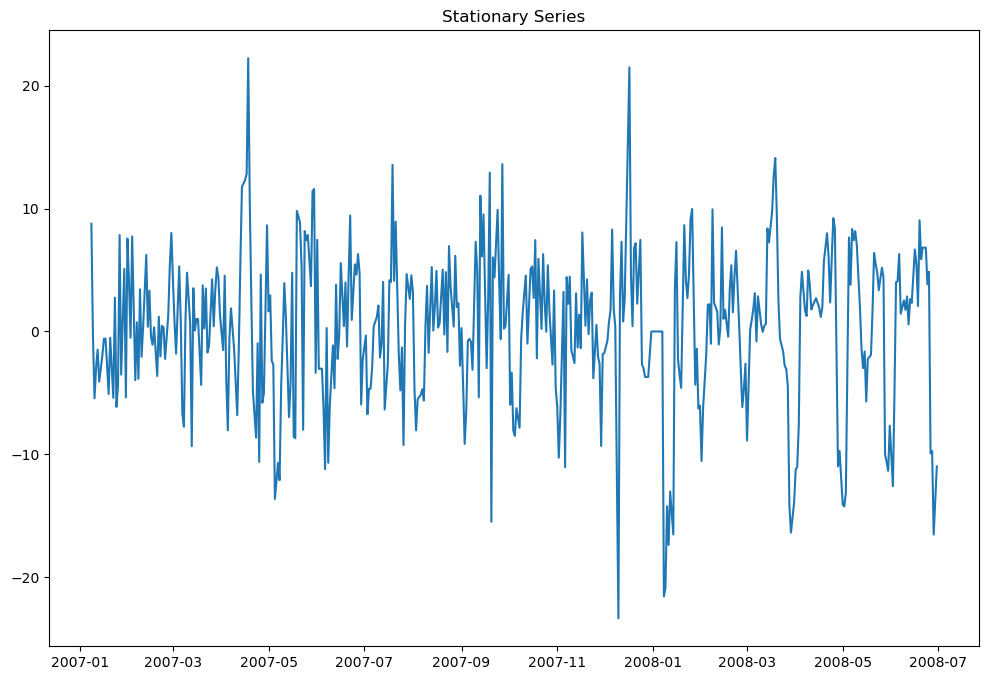

In [70]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['Sales_log_diff'])
plt.title("Stationary Series")
plt.show()

In [71]:
train_data['Sales_log_diff_diff'] = train_data['Sales_log_diff']-train_data['Sales_log_diff'].shift(1)

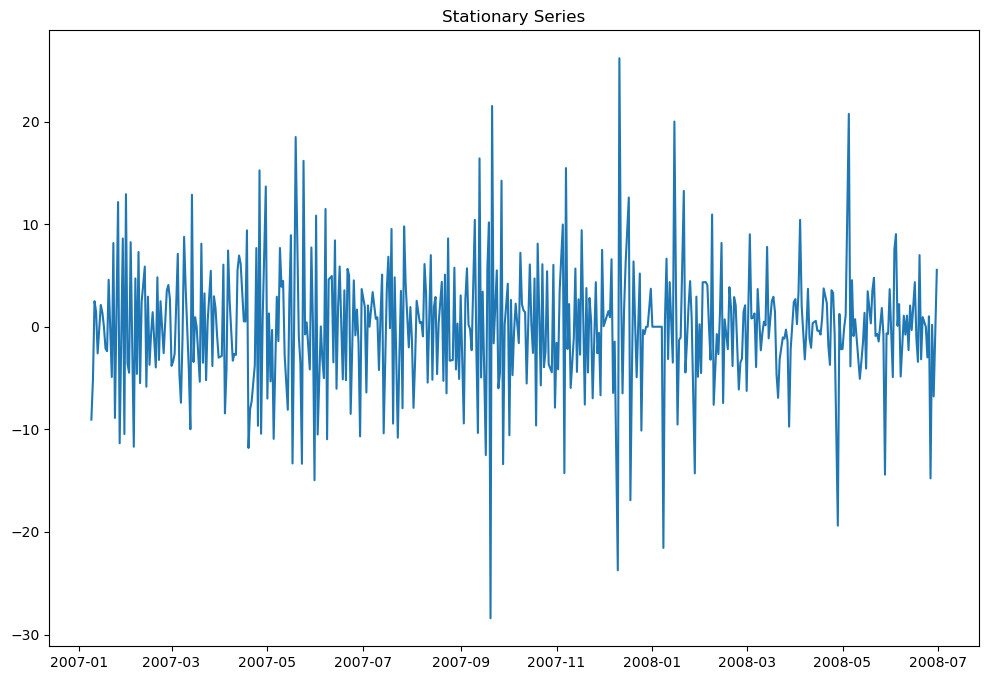

In [72]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data['Sales_log_diff_diff'])

plt.title("Stationary Series")
plt.show()

In [73]:
adf_test(train_data['Sales_log_diff_diff'].dropna())

Result of Augmented Dickey fuller (ADF) Test:
Test Statistics            -8.564695e+00
p-value                     8.508783e-14
No. of lags used            1.800000e+01
No. of observations used    4.430000e+02
Critical Vlaue (1%)        -3.445198e+00
Critical Vlaue (5%)        -2.868086e+00
Critical Vlaue (10%)       -2.570257e+00
dtype: float64


### Get p,d,q for ARIMA

There are three mehtods to compute best value of p,d and q for ARIMA model
1. By using ACF(q) and PACF plot(p)
2. By auto_ARIMA method
3. By iterations

#### ACF and PACF plot

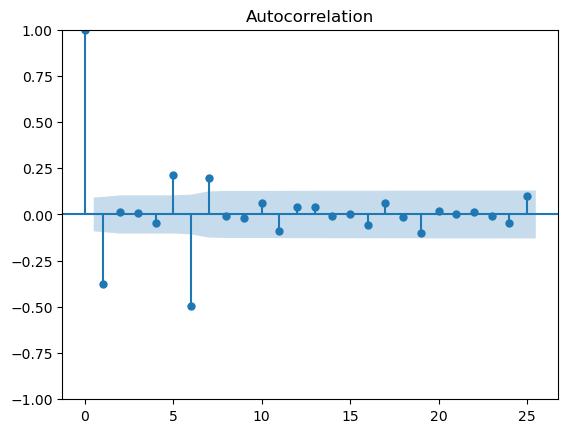

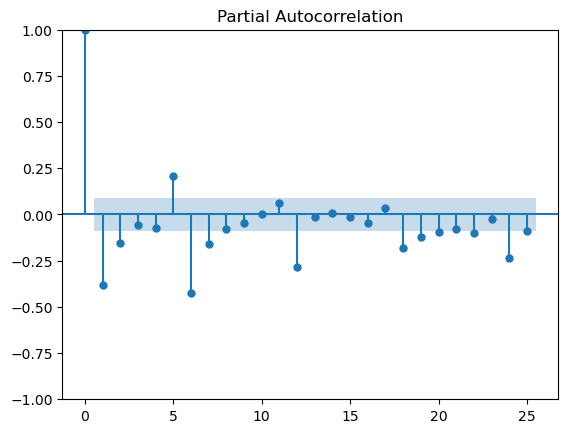

In [74]:
plot_acf(train_data['Sales_log_diff_diff'].dropna(), lags=25)
plot_pacf(train_data['Sales_log_diff_diff'].dropna(), lags=25)
plt.show()

## ARIMA Model

In [75]:
start = len(train_data)+1
end = len(train_data)+len(validation_data)

def get_best_params(parameters_list):
        
    for p,d,q in parameters_list:
        
        best_order = None
        least_error = float("inf")
        
        model = ARIMA(train_data['Sales_log'],order=(p,d,q))
        model_fit = model.fit()
        
        preds = model_fit.predict(start=start,end = end)
        preds = inverse_boxcox(y=preds,lambda_=lambda_ar)
        preds.index = validation_data.index

        error = rmsle(actual=validation_data['Sales'],preds=preds)
                
        if error < least_error:
            least_error = error
            best_order = (p,d,q)
            
        #print('ARIMA %s RMSLE=%.3f' % ((p,d,q),error))
    print('Best ARIMA %s least RMSLE=%.3f' % (best_order,least_error))

In [76]:
# setting initial values and some bounds for them
p = range(1,6)
d = range(0,3) 
q = range(1,6)

# creating list with all the possible combinations of parameters
parameters = product(p, d, q)
parameters_list = list(parameters)

get_best_params(parameters_list)

Best ARIMA (5, 2, 5) least RMSLE=0.571


In [77]:
start = len(train_data['Sales'])+1
end = len(train_data['Sales'])+len(validation_data['Sales'])

model = ARIMA(train_data['Sales_log'],order=(5,2,5))
model_fit = model.fit()

print(model_fit.summary())

ar_preds = model_fit.predict(start=start,end = end)
arima_preds = inverse_boxcox(y=ar_preds,lambda_=lambda_ar)
arima_preds.index = validation_data.index

error = rmsle(actual=validation_data['Sales'],preds=arima_preds)
print('RMSLE correponding to optimized (p,d,q) vlaues: %.2f' %error)

                               SARIMAX Results                                
Dep. Variable:              Sales_log   No. Observations:                  469
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -1328.093
Date:                Sat, 28 Jan 2023   AIC                           2678.187
Time:                        12:54:34   BIC                           2723.796
Sample:                             0   HQIC                          2696.136
                                - 469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3336      0.141     -9.472      0.000      -1.610      -1.058
ar.L2         -0.7760      0.120     -6.478      0.000      -1.011      -0.541
ar.L3          0.1588      0.132      1.198      0.2

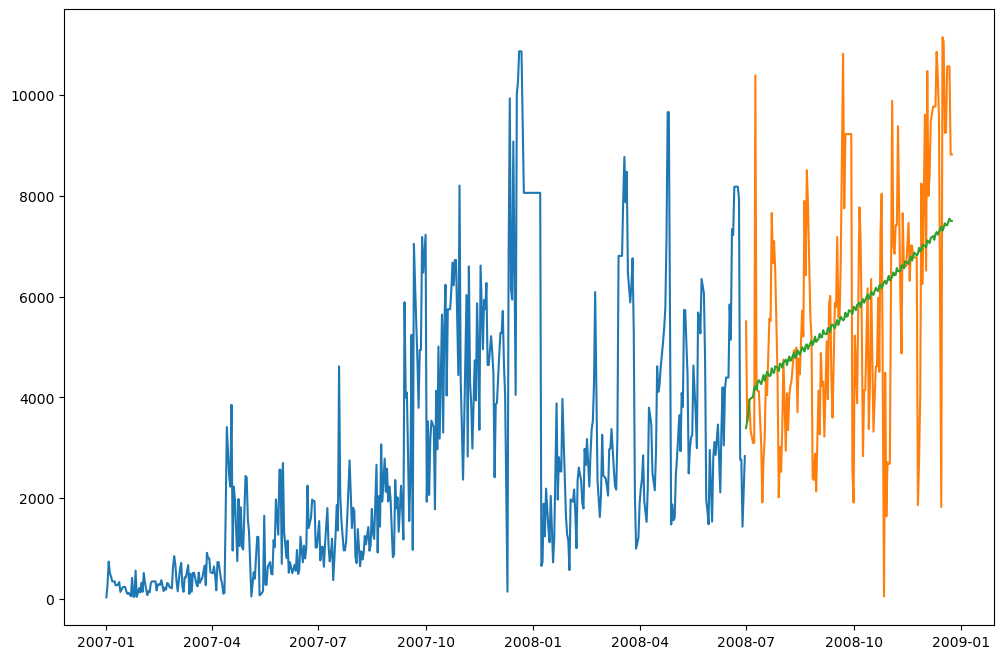

In [78]:
plt.figure(figsize = (12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(validation_data.index, arima_preds, label = 'arima_preds')
plt.show()

In [79]:
forecast_start = len(train_data)+len(validation_data)+1
forecast_end = forecast_start + 179

six_month_forecast_ar = model_fit.predict(start=forecast_start,end = forecast_end)
six_month_forecast_arima= inverse_boxcox(y=six_month_forecast_ar,lambda_=lambda_ar)

In [80]:
six_month_forecast_arima.index = pd.date_range("2008-12-25", freq="D", periods=180)

In [81]:
six_month_forecast_arima

2008-12-25     7606.942110
2008-12-26     7622.926855
2008-12-27     7566.207955
2008-12-28     7690.326241
2008-12-29     7707.937199
                  ...     
2009-06-18    13669.876059
2009-06-19    13637.607596
2009-06-20    13702.895894
2009-06-21    13777.863074
2009-06-22    13795.303098
Freq: D, Name: predicted_mean, Length: 180, dtype: float64

In [82]:
validation_data.index

DatetimeIndex(['2008-07-01', '2008-07-02', '2008-07-03', '2008-07-04',
               '2008-07-05', '2008-07-07', '2008-07-08', '2008-07-09',
               '2008-07-10', '2008-07-11',
               ...
               '2008-12-13', '2008-12-15', '2008-12-16', '2008-12-17',
               '2008-12-18', '2008-12-19', '2008-12-20', '2008-12-22',
               '2008-12-23', '2008-12-24'],
              dtype='datetime64[ns]', name='Date', length=152, freq=None)

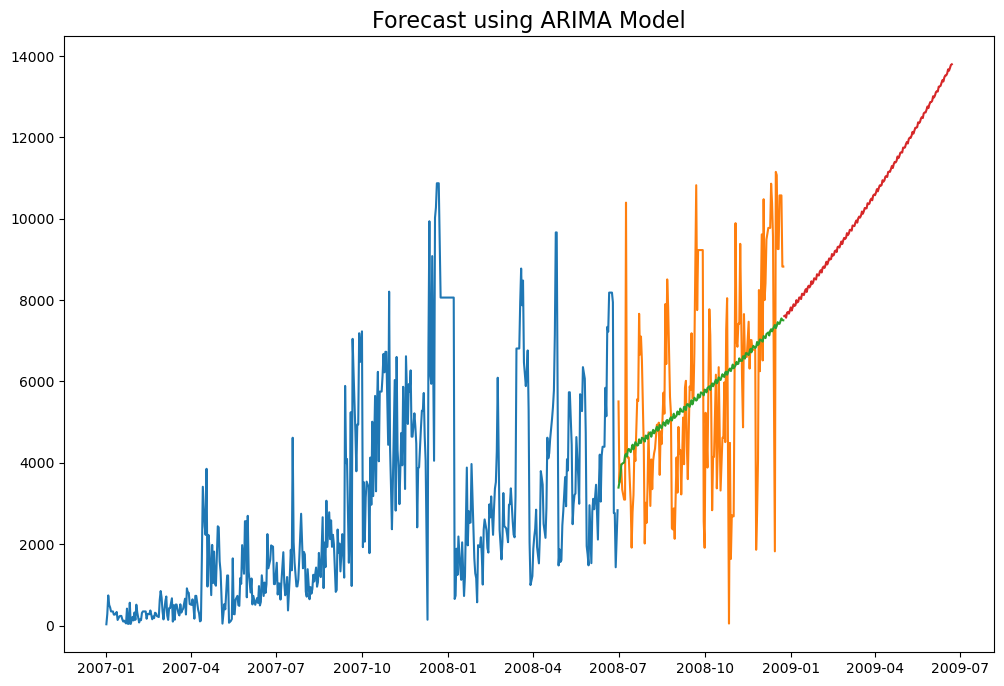

In [83]:
plt.figure(figsize = (12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(validation_data.index, arima_preds, label = 'arima_preds')
plt.plot(six_month_forecast_arima.index, six_month_forecast_arima, label = 'six_month')
plt.title('Forecast using ARIMA Model', fontsize=16)
plt.show()

## SARIMA Model

SInce it is weekly seasonality

In [84]:
def optimize_SARIMA(parameters_list, s = 6):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    values = {'p':[],'d':[],'q':[],'P':[],'D':[],'Q':[],'s':[],'RMSLE':[]}
    
    start = len(train_data)+1
    end = len(train_data) + len(validation_data)
    
    for param in tqdm_notebook(parameters_list):
        
        best_order = None
        least_error = float("inf")
        
        model = SARIMAX(train_data['Sales_log'], order = (param[0], param[1], param[2]), 
                        seasonal_order=(param[3], param[4], param[5], param[6]),initialization='approximate_diffuse').fit()
        
        preds = model.predict(start = start,end = end)
        sar_preds = inverse_boxcox(y=preds,lambda_=lambda_ar)
        
        sar_preds.index = validation_data.index

        error = rmsle(actual=validation_data['Sales'],preds=sar_preds)
        
        values['p'].append(param[0])
        values['d'].append(param[1])
        values['q'].append(param[2])        
        values['P'].append(param[3])
        values['D'].append(param[4])
        values['Q'].append(param[5])
        values['s'].append(param[6])
        
        values['RMSLE'].append(error)
        
        if error < least_error:
            least_error = error
            best_order = param
    
        #print('ARIMA %s RMSLE=%.3f' % ((p,d,q),error))
        df = pd.DataFrame(values)
    print('Best SARIMA (p,d,q,P,D,Q,s) = %s least RMSLE = %.3f' % (best_order,least_error))
    return df

In [85]:
p = range(2)
d = range(2)
q = range(2)
P = range(3)
D = range(2)
Q = range(3)
s = range(5,8)
parameters = product(p,d,q,P, D, Q,s)
parameters_list = list(parameters)
print(len(parameters_list))

432


In [86]:
start = len(train_data['Sales'])+1
end = len(train_data['Sales'])+len(validation_data['Sales'])

model = SARIMAX(train_data['Sales_log'],order=(1,1,2),seasonal_order=(1,1,2,6),
                initialization='approximate_diffuse')
model_fit = model.fit()

print(model_fit.summary())

sarima_preds = model_fit.predict(start=start,end = end)
sarima_preds = inverse_boxcox(y=sarima_preds,lambda_=lambda_ar)
sarima_preds.index = validation_data.index

error = rmsle(actual=validation_data['Sales'],preds=sarima_preds)
print('RMSLE correponding to optimized (p,d,q) vlaues: %.2f' %error)

                                     SARIMAX Results                                     
Dep. Variable:                         Sales_log   No. Observations:                  469
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 6)   Log Likelihood               -1418.001
Date:                           Sat, 28 Jan 2023   AIC                           2850.002
Time:                                   12:54:36   BIC                           2879.057
Sample:                                        0   HQIC                          2861.434
                                           - 469                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7617      0.077      9.907      0.000       0.611       0.912
ma.L1         -1.2536      0.084    -14.898

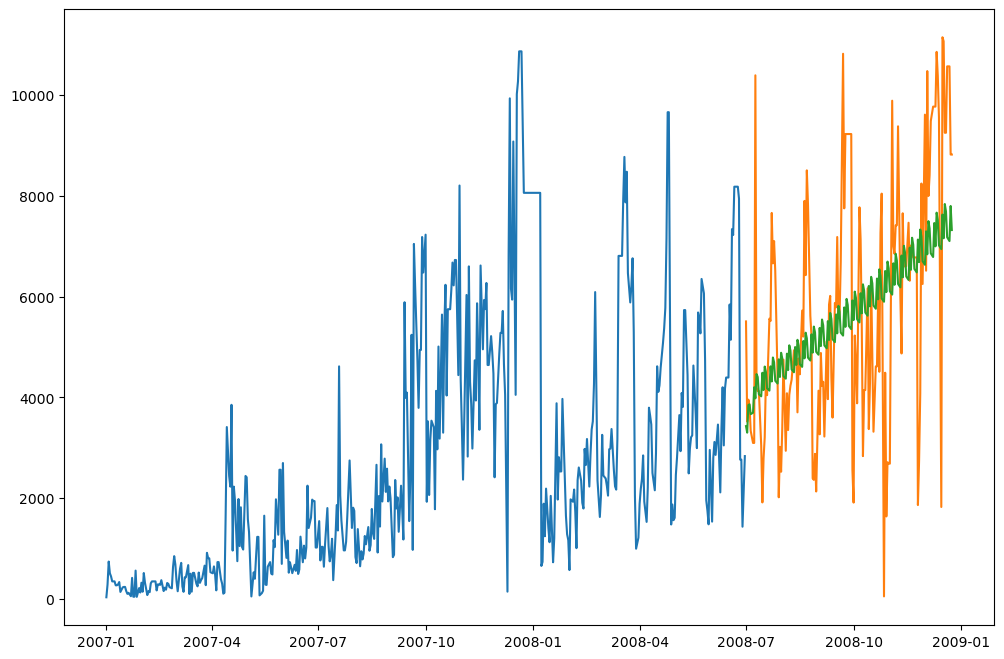

In [87]:
plt.figure(figsize = (12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(validation_data.index, sarima_preds, label = 'sarima_preds')
plt.show()

In [88]:
forecast_start = len(train_data)+len(validation_data)+1
forecast_end = forecast_start + 179

six_month_forecast_sar = model_fit.predict(start=forecast_start,end = forecast_end)
six_month_forecast_sarima= inverse_boxcox(y=six_month_forecast_sar,lambda_=lambda_ar)

six_month_forecast_sarima.index = pd.date_range("2008-12-25", freq="D", periods=180)

In [89]:
six_month_forecast_sarima.index

DatetimeIndex(['2008-12-25', '2008-12-26', '2008-12-27', '2008-12-28',
               '2008-12-29', '2008-12-30', '2008-12-31', '2009-01-01',
               '2009-01-02', '2009-01-03',
               ...
               '2009-06-13', '2009-06-14', '2009-06-15', '2009-06-16',
               '2009-06-17', '2009-06-18', '2009-06-19', '2009-06-20',
               '2009-06-21', '2009-06-22'],
              dtype='datetime64[ns]', length=180, freq='D')

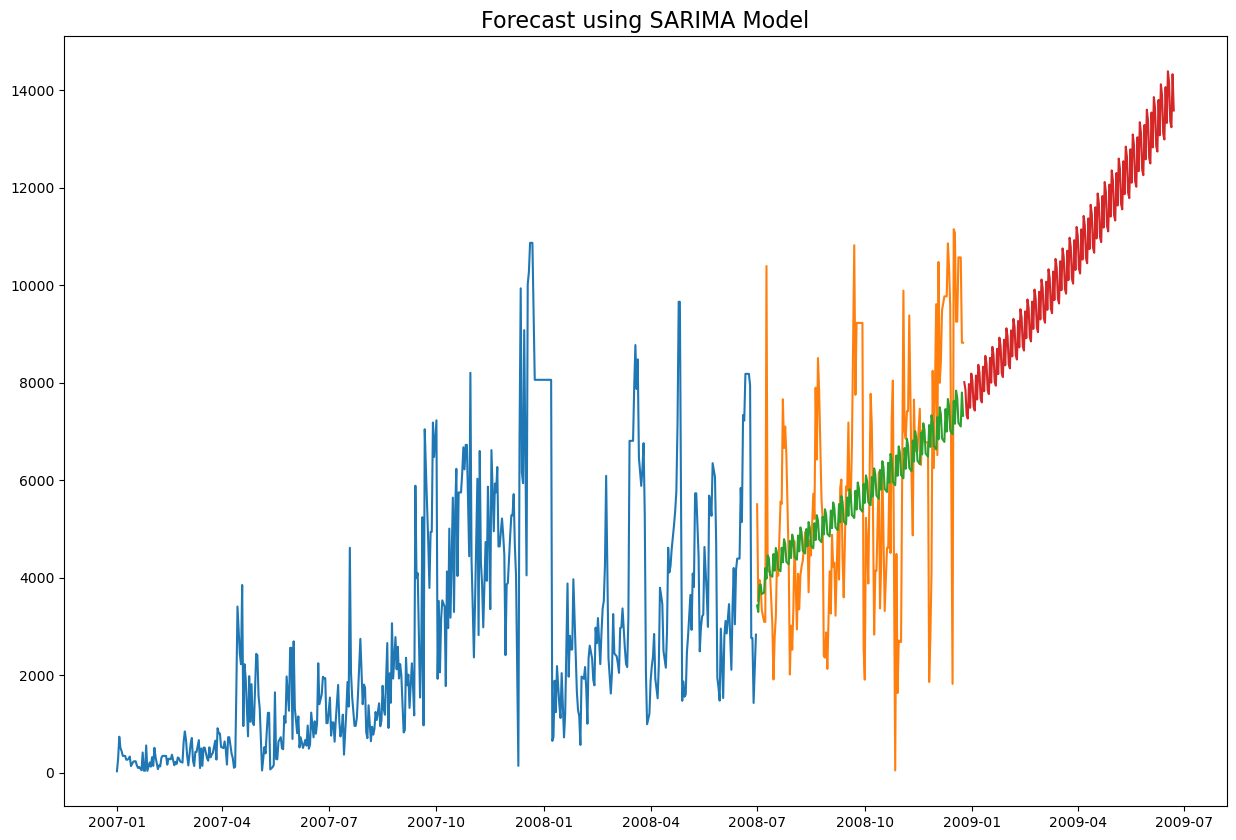

In [90]:
plt.figure(figsize = (15,10))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'valid')
plt.plot(validation_data.index, sarima_preds, label = 'arima_preds')
plt.plot(six_month_forecast_sarima.index, six_month_forecast_sarima, label = 'six_month')
plt.title('Forecast using SARIMA Model', fontsize=16)
plt.show()

# Building ML Models

In [91]:
complete_data.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter,Sales
2007-01-01,2007,1,1,0,1,1,1,31.762
2007-01-02,2007,1,2,1,2,1,1,285.955
2007-01-03,2007,1,3,2,3,1,1,740.781
2007-01-04,2007,1,4,3,4,1,1,508.796
2007-01-05,2007,1,5,4,5,1,1,445.951


In [92]:
train_data = complete_data[:469]
validation_data = complete_data[469:]

In [93]:
validation_data.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter,Sales
2008-07-01,2008,7,1,1,183,27,3,5508.723
2008-07-02,2008,7,2,2,184,27,3,3519.382
2008-07-03,2008,7,3,3,185,27,3,3955.195
2008-07-04,2008,7,4,4,186,27,3,3832.665
2008-07-05,2008,7,5,5,187,27,3,3336.381


In [94]:
# separating features and target variable
x_train = train_data.drop(['Sales'], axis=1)
y_train = train_data['Sales']

x_validation = validation_data.drop(['Sales'], axis=1)
y_validation = validation_data['Sales']

### Linear Regression

In [95]:
#training the model
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

lin_preds = lin_model.predict(x_validation)

# results
score = rmsle(y_validation,lin_preds)

print('RMSLE for Linear Regression is', score)

RMSLE for Linear Regression is 0.6362842449441606


In [96]:
feature_coeff = pd.DataFrame(zip(x_train.columns, lin_model.coef_), columns=['Feature', 'coeff'])
feature_coeff

,Feature,coeff
0,year,2766.191399
1,month,-11052.716283
2,dayofmonth,-334.830843
3,weekday,70.927690
4,dayofyear,387.671856
5,week,-45.479537
6,quarter,-93.550572


<BarContainer object of 7 artists>

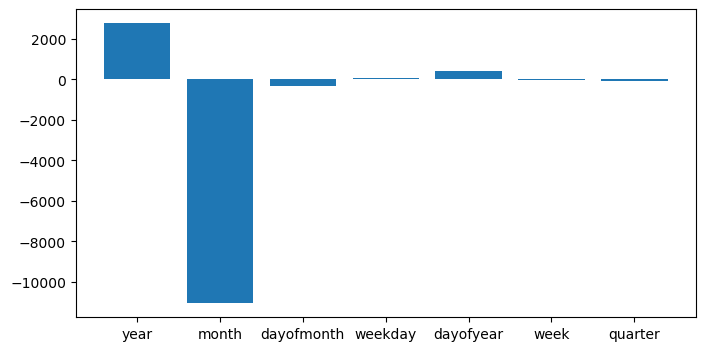

In [97]:
plt.figure(figsize=(8,4))
plt.bar(feature_coeff['Feature'], feature_coeff['coeff'])

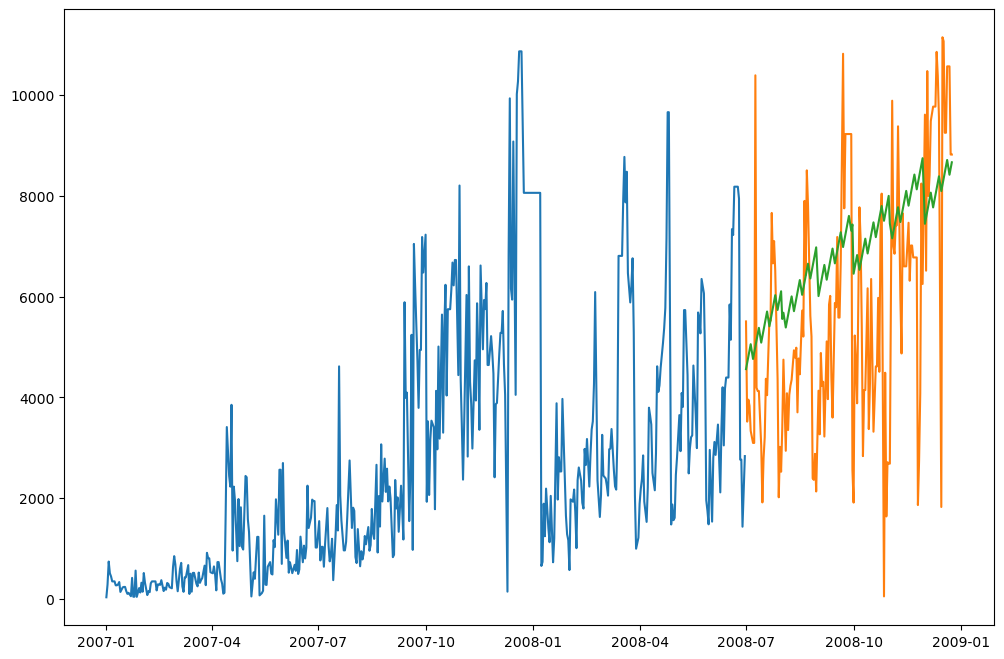

In [98]:
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'validation')
plt.plot(validation_data.index, lin_preds, label = 'preds')
plt.show()

### Regularization for Linear Regression

In [99]:
for alpha in [0.01, 0.05, 0.1, 0.5, 1, 5]:
    print('----- ----- ----- ----- -----')
    print('At alpha value:', alpha)

    #training the model
    model = Ridge(alpha = alpha, normalize=True)
    model.fit(x_train, y_train)

    # predictions 
    preds = model.predict(x_validation)
    score = rmsle(y_validation, preds)

    # results
    print('RMSLE:', score)

----- ----- ----- ----- -----
At alpha value: 0.01
RMSLE: 0.6275748759847227
----- ----- ----- ----- -----
At alpha value: 0.05
RMSLE: 0.6206194234170089
----- ----- ----- ----- -----
At alpha value: 0.1
RMSLE: 0.6113127928864853
----- ----- ----- ----- -----
At alpha value: 0.5
RMSLE: 0.5755631506350773
----- ----- ----- ----- -----
At alpha value: 1
RMSLE: 0.5759422483826827
----- ----- ----- ----- -----
At alpha value: 5
RMSLE: 0.6773839488814898


In [100]:
#training the model
ridge_model = Ridge(alpha = 0.5, normalize=True)
ridge_model.fit(x_train, y_train)

# predictions 
ridge_preds = ridge_model.predict(x_validation)
score = rmsle(y_validation, ridge_preds)

# results
print('Linear Regression error is', score)

Linear Regression error is 0.5755631506350773


In [101]:
feature_coeff = pd.DataFrame(zip(x_train.columns, ridge_model.coef_), columns=['Feature', 'coeff'])
feature_coeff

,Feature,coeff
0,year,1738.272770
1,month,103.986614
2,dayofmonth,27.000168
3,weekday,51.388088
4,dayofyear,3.649241
5,week,21.474726
6,quarter,251.187846


<BarContainer object of 7 artists>

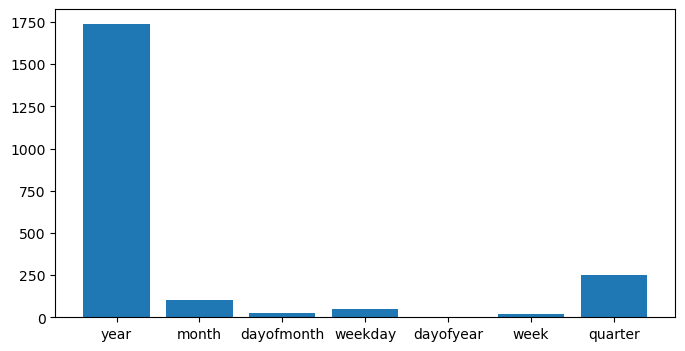

In [102]:
plt.figure(figsize=(8,4))
plt.bar(feature_coeff['Feature'], feature_coeff['coeff'])

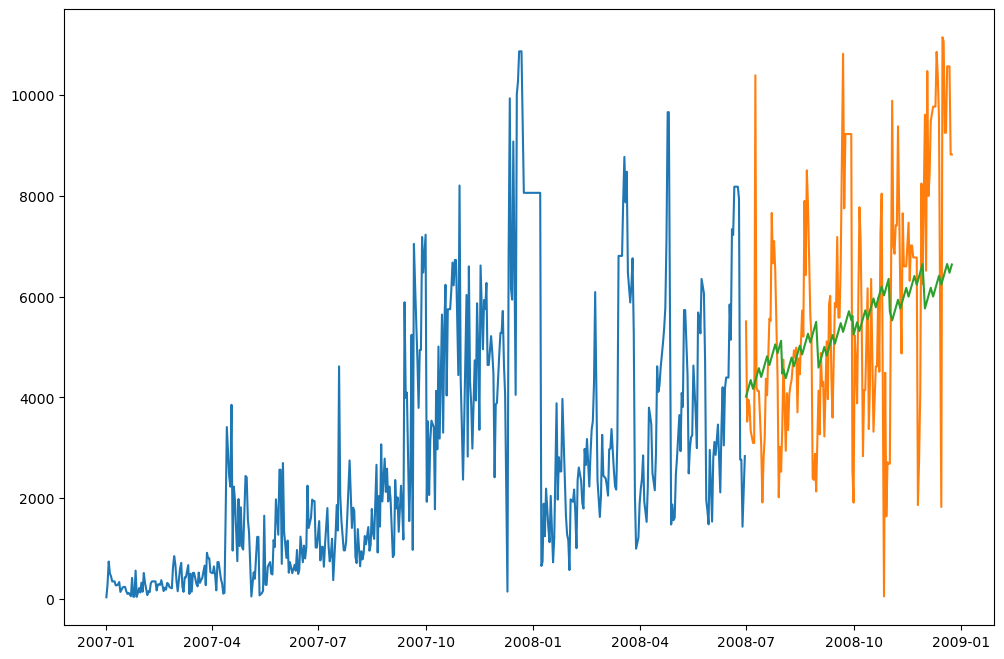

In [103]:
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'validation')
plt.plot(validation_data.index, ridge_preds, label = 'preds')
plt.show()

### Random Forest

In [104]:
#training the model
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(x_train, y_train)
    
# predictions 
rf_preds = rf_model.predict(x_validation)

score = rmsle(y_validation, rf_preds)
   
# results
print('Average Error is',score)

Average Error is 0.5726409340639825


Text(0.5, 0, 'Relative Importance')

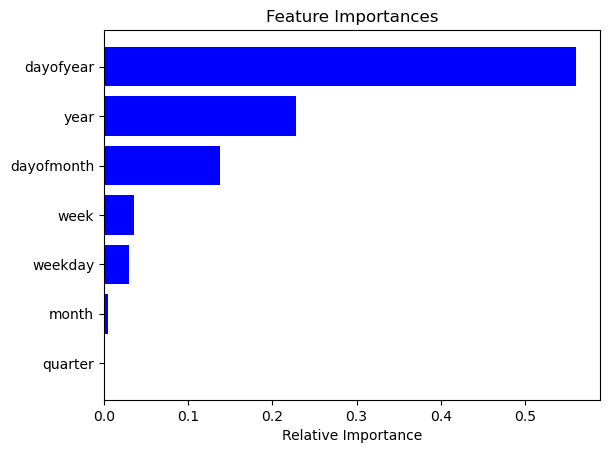

In [105]:
features = x_train.columns
importances =rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

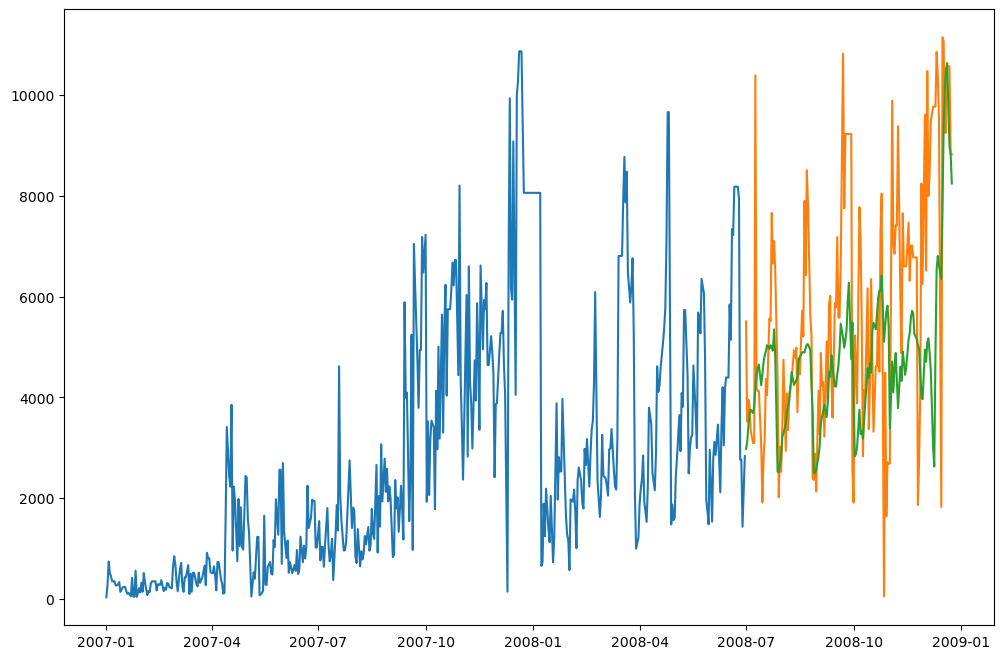

In [106]:
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'validation')
plt.plot(validation_data.index, rf_preds, label = 'preds')
plt.show()

### Random Forest Hyperparamter Tuning

In [107]:
# setting initial values and some bounds for them
n_estimator = [70, 100, 130, 150]
max_depth =  [5, 6, 7, 8, 9]
min_samples_split = [20, 30, 50]


# creating list with all the possible combinations of parameters
parameters_rf = product(n_estimator, max_depth, min_samples_split)
parameters_list_rf = list(parameters_rf)
len(parameters_list_rf)

60

In [108]:
def grid_search_random_forest(parameters_list):
    
    results = []
    best_error_ = float("inf")

    for param in tqdm_notebook(parameters_list):
        
        #training the model
        model = RandomForestRegressor(n_estimators=param[0],max_depth=param[1],min_samples_split = param[2],random_state=0)
        model.fit(x_train, y_train)

        # predictions 
        preds = model.predict(x_validation)

        # predictions and evaluation
        score = rmsle(y_validation, preds)
        
        # saving best model, rmse and parameters
        if score < best_error_:
            best_error_ = score
            best_param = param
        results.append([param, score])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'score']
    
    
    # sorting in ascending order, the lower rmse is - the better
    result_table = result_table.sort_values(by='score', ascending=True).reset_index(drop=True)
    
    return result_table

In [109]:
tuned_params_rf = grid_search_random_forest(parameters_list=parameters_list_rf)

  0%|          | 0/60 [00:00<?, ?it/s]

In [110]:
tuned_params_rf.head()

,parameters,score
0,"(150, 6, 50)",0.554940
1,"(150, 9, 50)",0.554969
2,"(150, 8, 50)",0.554969
3,"(150, 7, 50)",0.554969
4,"(130, 9, 50)",0.555639


In [111]:
#training the model
rf_model = RandomForestRegressor(n_estimators=150, max_depth=6, min_samples_split = 50, random_state=0)
rf_model.fit(x_train, y_train)
    
# predictions 
rf_preds = rf_model.predict(x_validation)

score = rmsle(y_validation, rf_preds)
   
# results
print('Average Error is',score)

Average Error is 0.5549396067801106


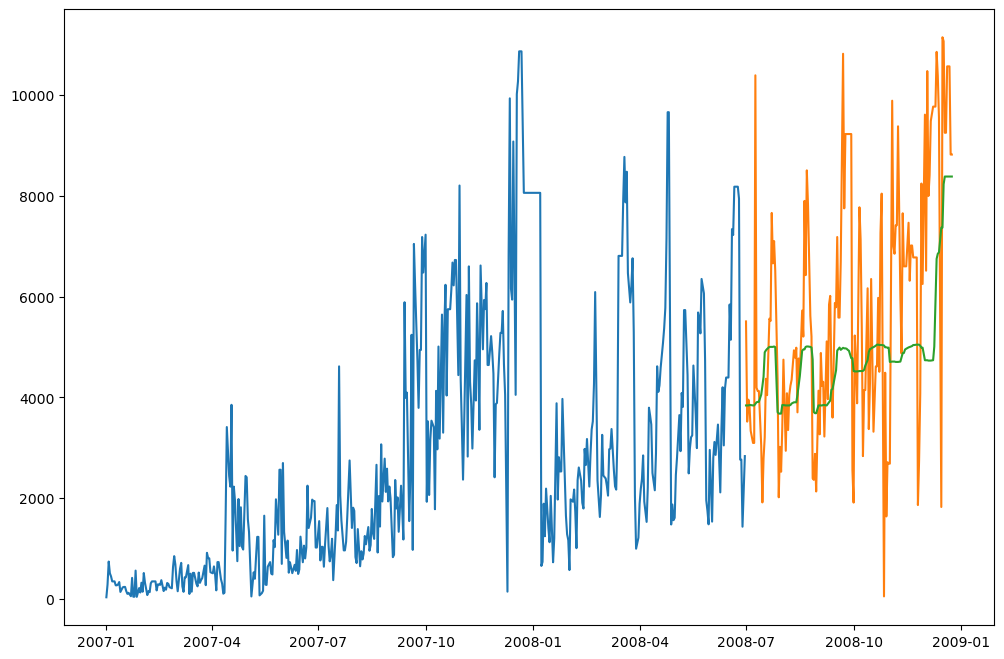

In [112]:
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'validation')
plt.plot(validation_data.index, rf_preds, label = 'preds')
plt.show()

### XGB Regressor

In [113]:
#training the model
xgb_model = XGBRegressor(random_state=0)
xgb_model.fit(x_train, y_train)
    
# predictions 
xgb_preds = xgb_model.predict(x_validation)

score = rmsle(y_validation, xgb_preds)
   
# results
print('Average Error is',score)

Average Error is 0.5890400705635704


In [114]:
# setting initial values and some bounds for them
n_estimator = [70, 100, 130, 150]
max_depth =  [5, 8, 10, 12, 15]
learning_rate = [0.05, 0.2, 0.3, 0.5]

# creating list with all the possible combinations of parameters
parameters_xgb = product(n_estimator, max_depth, learning_rate)
parameters_list_xgb = list(parameters_xgb)
len(parameters_list_xgb)

80

In [115]:
def grid_search_xgb(parameters_list):
    
    results = []
    best_error_ = float("inf")

    for param in tqdm_notebook(parameters_list):
        
        #training the model
        model = XGBRegressor(n_estimators=param[0],max_depth=param[1],learning_rate = param[2],random_state=0)
        model.fit(x_train, y_train)

        # predictions 
        preds = model.predict(x_validation)

        # predictions and evaluation
        score = rmsle(y_validation, preds)
        
        # saving best model, rmse and parameters
        if score < best_error_:
            best_model = model
            best_error_ = score
            best_param = param
        results.append([param, score])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'score']
    
    
    # sorting in ascending order, the lower rmse is - the better
    result_table = result_table.sort_values(by='score', ascending=True).reset_index(drop=True)
    
    return result_table

In [116]:
tuned_params_xgb = grid_search_xgb(parameters_list=parameters_list_xgb)

  0%|          | 0/80 [00:00<?, ?it/s]

In [117]:
tuned_params_xgb.head()

,parameters,score
0,"(70, 5, 0.3)",0.576669
1,"(70, 5, 0.5)",0.577320
2,"(100, 5, 0.3)",0.583642
3,"(100, 5, 0.5)",0.588501
4,"(130, 5, 0.3)",0.590167


In [118]:
xgb_model = XGBRegressor(n_estimators=70, max_depth=5,learning_rate = 0.3, random_state=0)
xgb_model.fit(x_train, y_train)

# predictions 
xgb_preds = xgb_model.predict(x_validation)

# predictions and evaluation
score = rmsle(y_validation, xgb_preds)

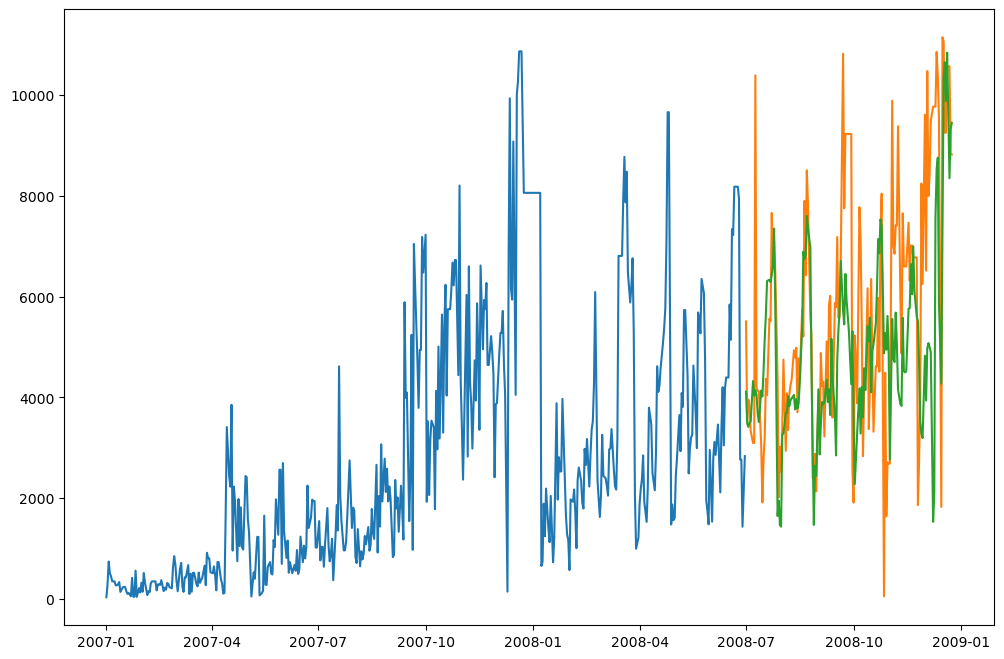

In [119]:
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Sales'], label = 'train')
plt.plot(validation_data.index, validation_data['Sales'], label = 'validation')
plt.plot(validation_data.index, xgb_preds, label = 'preds')
plt.show()

In [120]:
test_set = pd.DataFrame(data = pd.date_range(start = '2008-12-25', end= '2009-06-24', freq = 'D'),
                        columns=['Date'])
test_set.head()

,Date
0,2008-12-25
1,2008-12-26
2,2008-12-27
3,2008-12-28
4,2008-12-29


In [121]:
test_feat = pd.DataFrame({"year": test_set['Date'].dt.year,
                          "month": test_set['Date'].dt.month,
                          "dayofmonth": test_set['Date'].dt.day,
                          "weekday": test_set['Date'].dt.dayofweek,
                          "dayofyear": test_set['Date'].dt.dayofyear,
                          "week": test_set['Date'].dt.week,
                          "quarter": test_set['Date'].dt.quarter,
                         })

In [122]:
test_feat.index = test_set['Date']

In [123]:
test_feat.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter
Date,,,,,,,
2008-12-25,2008,12,25,3,360,52,4
2008-12-26,2008,12,26,4,361,52,4
2008-12-27,2008,12,27,5,362,52,4
2008-12-28,2008,12,28,6,363,52,4
2008-12-29,2008,12,29,0,364,1,4


In [124]:
complete_data.head()

,year,month,dayofmonth,weekday,dayofyear,week,quarter,Sales
2007-01-01,2007,1,1,0,1,1,1,31.762
2007-01-02,2007,1,2,1,2,1,1,285.955
2007-01-03,2007,1,3,2,3,1,1,740.781
2007-01-04,2007,1,4,3,4,1,1,508.796
2007-01-05,2007,1,5,4,5,1,1,445.951


In [125]:
test_feat.describe()

,year,month,dayofmonth,weekday,dayofyear,week,quarter
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,2008.961538,3.752747,15.686813,3.000000,98.576923,14.071429,1.582418
std,0.192838,2.333841,8.809572,2.005517,72.662180,9.248584,0.690359
min,2008.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,2009.000000,2.000000,8.000000,1.000000,46.250000,7.000000,1.000000
50%,2009.000000,4.000000,16.000000,3.000000,91.500000,13.500000,2.000000
75%,2009.000000,5.000000,23.000000,5.000000,136.750000,20.000000,2.000000
max,2009.000000,12.000000,31.000000,6.000000,366.000000,52.000000,4.000000


In [126]:
test_feat.isnull().sum()

year          0
month         0
dayofmonth    0
weekday       0
dayofyear     0
week          0
quarter       0
dtype: int64

In [127]:
X_train = complete_data.drop(['Sales'], axis=1)
y_train = complete_data['Sales']

X_test = test_feat

In [128]:
#training the model
model = RandomForestRegressor(n_estimators=150, max_depth=6, min_samples_split = 50, random_state = 0)
model.fit(X_train, y_train)
    
# predictions 
pred_rf_train = model.predict(X_train)
pred_rf_test = model.predict(X_test)

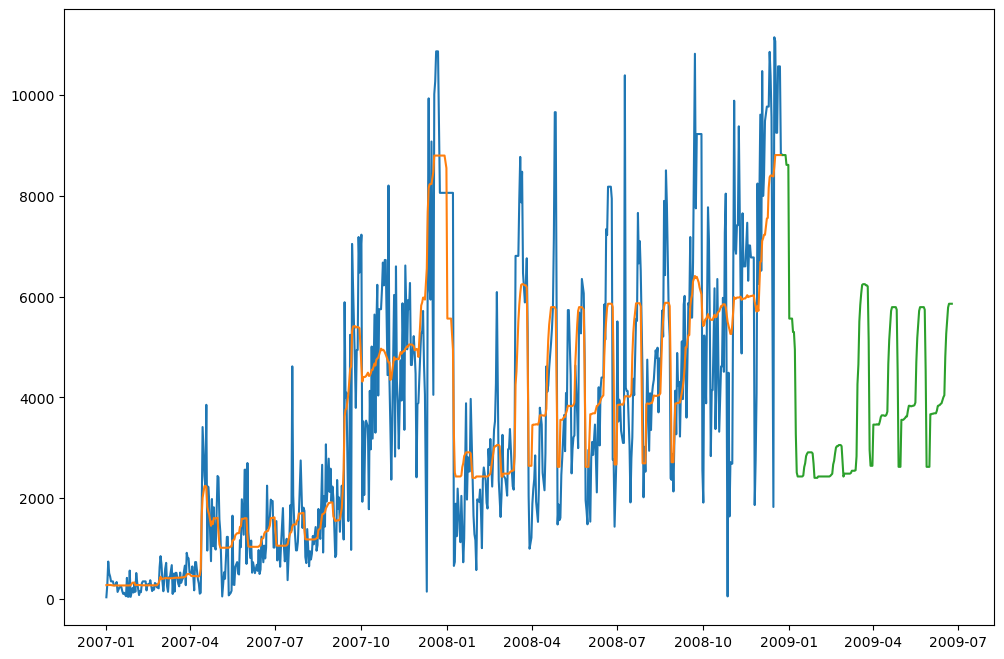

In [129]:
plt.figure(figsize = (12,8))

plt.plot(complete_data.index, complete_data['Sales'], label = 'train')
plt.plot(complete_data.index, pred_rf_train, label = 'prediction on train')
plt.plot(test_feat.index, pred_rf_test, label = 'prediction on test')

plt.show()

### Let me Summarize all the steps teken in this project.
### 1. Overview of the overall dataset
   - We have daily sales data for two years, starting from 1-jan-07 to 24-dec-08.
   - Using this historical data, we need to forecast the demand expected in the next 6 months. 
    
### 2. Data Preprocessing
   - Clearly there are some very high values in the data. So the values beyond the upper whisker value are removed.  
   - There were also some missing dates. apart from sunday. So, using ffill method, i hav imputed the missing dates and removed sundays completely from series considering that store open from Monday to Saturday only.
   
### 3.Feature Extraction and Exploration
   - I It consist of decmposing the series into Trend, Seasonal and Resid
   - Apart from that i have extracted date related information like day, month, dayofyear, year etc. from Date column to have a better insights and findings are mentioned below:
       - Except for a few high sales in 2007, sales were comparatively higher in 2008
       - All weekdays have similar trend on sales
       - Average sales are higher towards the end of the year
   
### 4. Time Series Forecasting Models

The complete dataset is divided into two parts : Train and Validation dataset

- Validation dataset: It consist of last 6 months data from dataset
- Train dataset: It consist of remaining 1.5 year data from dataset

#### Time Series Models:

- **Holt' WInter Model( a.k.a. Traiple Exponential Smoothing)**
    - This method takes into account the three parameters such as : Level, Trend and Seasonality
    - I created grid_search function to find the optimal values of level, trend and seasonality and the retrained the model with these optimized hyper-parameters.
    - The minimum RMSLE reported through this method: 0.58
---

- **ARIMA Model**
    - This method consist of three componensts suc as AR, I and MA. AR menas autoregressive, I means integration (differencing) and MA means Moving average.
    - AR, I and MA are represented by p,d and q parameters in this model.
    - The values of p,d and q can be found out by various methods such as:
        - By using ACF and PACF plots
        - By usinf auto_arima  module
        - By iterations
    - I used iteration method and created grid_search function to find the optimal values of p,d and q and retrained the model with these optimized hyper-parameters.
    - The minimum RMSLE reported through this method: 0.57
    - It fails to caputure the seaonality in series
---
- **SARIMA Model**
    - This method is same as ARIMA model but in addition to that , a seasonal component is added that add four additional pararmeters such as P, D, Q and s which represent AR, I, MA and seasonality for seasonal components also.
    - AR, I and MA are represented by p,d and q parameters in this model.
    - The values of non seasonal componenets(p,d and q) and seasonal components (P,D,Q,s) can be found out by various methods such as:
        - By using ACF and PACF plots
        - By usinf auto_arima  module
        - By iterations
    - I used iteration method and created grid_search function to find the optimal values of non seasonal componenets(p,d and q) and seasonal components (P,D,Q,s) and retrained the model with these optimized hyper-parameters.
    - The minimum RMSLE reported through this method: 0.57 
    - It also captured the seasonaltiy of series 

### 4. Machine Learning Models
- **Linear Regression**
    - The minimum RMSLE reported through this method: 0.64
    - It also captured the seasonaltiy of series to some extent
---    
- **Ridge Regression**
    - The alpha value is tuned and get final alpha value 0.5 w.r.t. least error
    - The minimum RMSLE reported through this method: 0.57
    - It also captured the seasonaltiy of series to some extent
---    
- **Random Forest**
    - I have created custom grid_search_random_forest function to find out the best hyperparameters.
    - The best hyperparameters i got after tuning are:
        - n_estimators=150
        - max_depth=6
        - min_samples_split = 50
    - The minimum RMSLE reported after retraining the model through this method: 0.55
    - It also captured the seasonaltiy of series.
---
- **XGB Regressor**
    - I have created custom grid_search_xgb function to find out the best hyperparameters.
    - The best hyperparameters i got after tuning are:
        - n_estimators=70
        - max_depth=5
        - learning_rate = 0.3
    - The minimum RMSLE reported after retraining the model through this method: 0.57
    - It also captured the seasonaltiy of series.

# Conclusion

Out of all the models, Random Forest preformed best with respect to this particular problem so we can go with this model for next six months forecasting